In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyblock
from scipy.special import logsumexp
from scipy.special import softmax

# matplotlib settings
# --- Publication style settings ---
plt.rcParams.update({
    # Font
    "font.family": "Times New Roman",
    "font.serif": ["Arial"],  # or other preferred serif font
    "mathtext.fontset": "cm",            # Computer Modern for math text
    "text.usetex": False,                 # Use LaTeX for text rendering]
    "pdf.fonttype": 42,                 # Use LaTeX for text rendering

    # Figure
    "figure.figsize": (6, 4),            # width, height in inches
    "figure.dpi": 300,                   # high resolution

    # Axes
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.linewidth": 1.2,
    "axes.grid": True,                   # optional, remove if you want no grid
    "grid.linestyle": "--",
    "grid.alpha": 0.7,

    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,

    # Lines
    "lines.linewidth": 2,
    "lines.markersize": 6,

    # Legend
    "legend.fontsize": 10,
    "legend.frameon": False
})

# functions
# read_colvar function which sorts colvar for unique entries from the back (i.e., second entry retained)
def read_colvar(colvar_file):

    data = np.loadtxt(colvar_file)
    # inverse order
    data = data[::-1]
    unique_idxs = np.array(np.unique(data[:,0], return_index=True)[1]).astype(int)[::-1] # find unique indices, first occurences
    data = data[unique_idxs]
    # original order
    data = data[::-1]

    return data

output_path = '../ELVIM_data/ACTR/'
prod_name = '300K'
path = '../OPES_multiT/ACTR/NEW_PRODUCTION_300K_2fs_80steps/alldata/'

In [4]:
# weights & frames at 300 K (to compare with REST2)

kb=0.008314
T0 = 300
T=300
kbt = kb*T0
nsims = 5


# load data and concatenate
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')
        CVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        CVS = CVS[mask_data]
        frames = np.arange(CVS.shape[0])
    else:
        tmpdata = read_colvar(path+f'COLVAR.{sim}')
        tmpCVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = tmpdata[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpdata = tmpdata[mask_data]
        tmpCVS = tmpCVS[mask_data]
        tmpframes = np.arange(tmpCVS.shape[0])
        data = np.concatenate((data, tmpdata), axis=0)
        CVS = np.concatenate((CVS, tmpCVS), axis=0)
        frames = np.concatenate((frames, tmpframes), axis=0)

# downsample
data = data[::2]
CVS = CVS[::2]
frames = frames[::2]
print(np.min(frames))

# analysis of concatenated data
bias = data[:,2]
ene = data[:,1] # U
logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
w = softmax(logw)
w = w/np.sum(w)
# remove frames with w=0
mask = w != 0
#mask = w>1e-30
mask = w>1e-10
print(np.sum(w[mask]))
weights_clean = w[mask]
weights_clean = weights_clean/np.sum(weights_clean)
rgdata = CVS[:,1][mask]
alpha = CVS[:,2][mask]
frames = frames[mask]
print(np.average(rgdata, axis=0, weights=weights_clean))
print(np.average(alpha, axis=0, weights=weights_clean))
weights_clean.shape
        
    

0
0.9999997097427753
1.9890402359406048
4.971419372261428


(71354,)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


0
499797
(71354,)


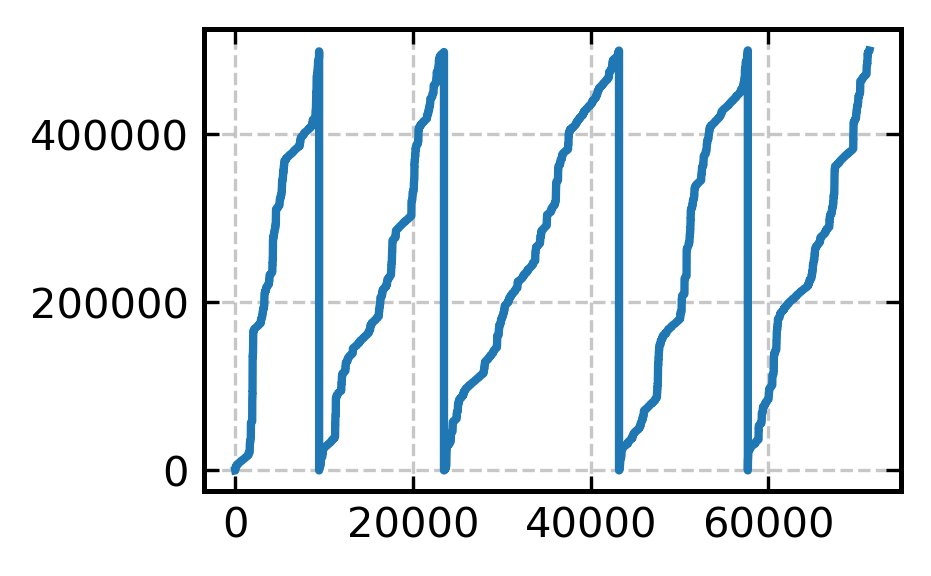

In [5]:
print(np.min(frames))
print(np.max(frames))
print(frames.shape)
plt.figure(figsize = (3, 2))
plt.plot(frames)
plt.show()

In [6]:
print(np.sum(weights_clean))
np.savetxt(output_path+"weights_opes_300K.txt", weights_clean)


0.9999999999999999


In [7]:
# calculate ESS
(weights_clean.sum()**2) / (np.sum(weights_clean**2))

24895.36524196914

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


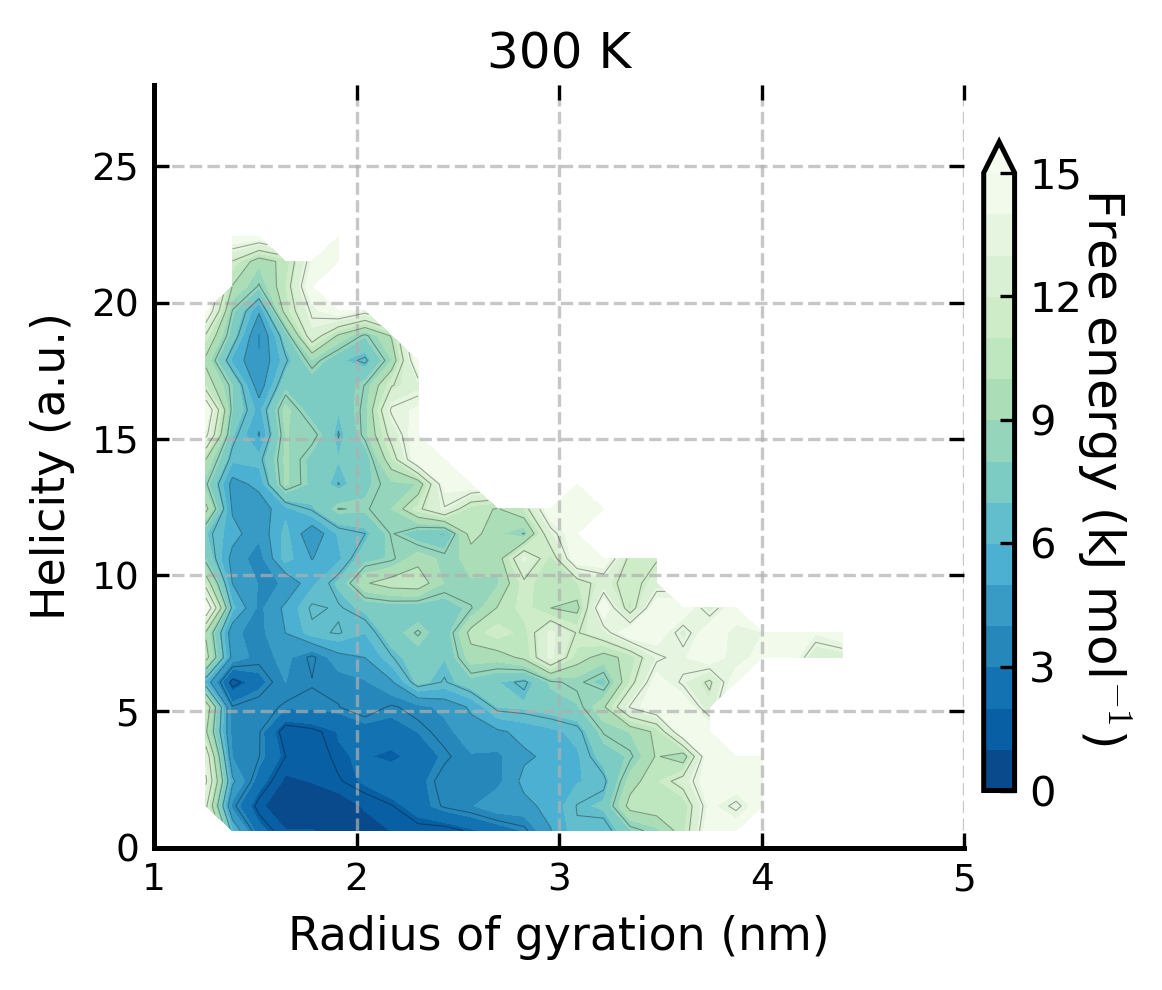

In [11]:
# save descriptors
np.savetxt(output_path+f"rg_opes_300K.txt", rgdata)
np.savetxt(output_path+f"alpharmsd_opes_300K.txt", alpha)


max_FEL = 15
kb=0.008314
T0 = 300
T = 300#
kbt = kb*T0
nsims = 5


# --- Compute 2D histogram ---
nbins = 25
H, xedges, yedges = np.histogram2d(rgdata, alpha, bins=nbins, weights=weights_clean, density=True)

# Avoid zeros for log
H[H <= 1e-15] = np.nan

# Convert probability to free energy (kJ/mol)
F = -kbt * np.log(H)
F = F - np.nanmin(F)  # shift minimum to 0

# Cap free energy to max FEL value
F[F > max_FEL] = max_FEL

# --- Grid centers for plotting ---
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])

# --- Pastel color map ---
cmap = plt.cm.viridis  # you can also try 'cividis', 'Spectral_r', or 'plasma'
from matplotlib.colors import LinearSegmentedColormap
pastel_cmap = LinearSegmentedColormap.from_list(
    "pastel_viridis", [plt.cm.viridis(0.1), plt.cm.viridis(0.6), plt.cm.viridis(0.9)], N=256
)

# plot

plt.figure(figsize=(4.0, 3.4), dpi=300)

# Smoother and fewer contour levels
levels = np.linspace(0, max_FEL, 16)

# Main contour plot
contour = plt.contourf(
    xcenters, ycenters, F.T,
    levels=levels,
    cmap='GnBu_r',
    extend='max'
)

for c in contour.collections:
    c.set_rasterized(True)

# --- Clean, sparse colorbar ---
cbar = plt.colorbar(contour, pad=0.02, shrink=0.85)
cbar.set_label(r"Free energy (kJ mol$^{-1}$)", rotation=270, labelpad=12)

# Fewer ticks (natural nice breakpoints)
cbar_ticks = np.linspace(0, max_FEL, 6)
cbar.set_ticks(cbar_ticks)

# --- Add subtle contour lines ---
plt.contour(
    xcenters, ycenters, F.T,
    levels=np.linspace(0, max_FEL, 10),
    colors='k',
    linewidths=0.25,
    alpha=0.35
)

# --- Refined axes ---
plt.xlabel(r"Radius of gyration (nm)", fontsize=11)
plt.ylabel("Helicity (a.u.)", fontsize=11)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

# Light padding
plt.xlim(1, 5)
plt.ylim(0, 28)

# Remove top & right spines (cleaner look)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.title(f"{T} K", fontsize=12, pad=4)

plt.tight_layout()



In [4]:
def split_on_drop(arr):
    arr = np.asarray(arr)
    # find where index drops
    drop_points = np.where(arr[1:] < arr[:-1])[0] + 1
    
    # split array at drop points
    parts = np.split(arr, drop_points)
    return parts

# split indices
split_frames = split_on_drop(frames)
for idx, sframes in enumerate(split_frames):
    with open(output_path+f'frames_opes_300K_{idx}.ndx', 'w') as f:
        f.write('[ frames ]\n')
        for ele in sframes:
            f.write(f'{int(ele+1)}\n') # +1 because gromacs frames index starts at 1

            

In [12]:
for i in range(len(split_frames)):
    print(len(split_frames[i]))

9434
14050
19697
14498
13675


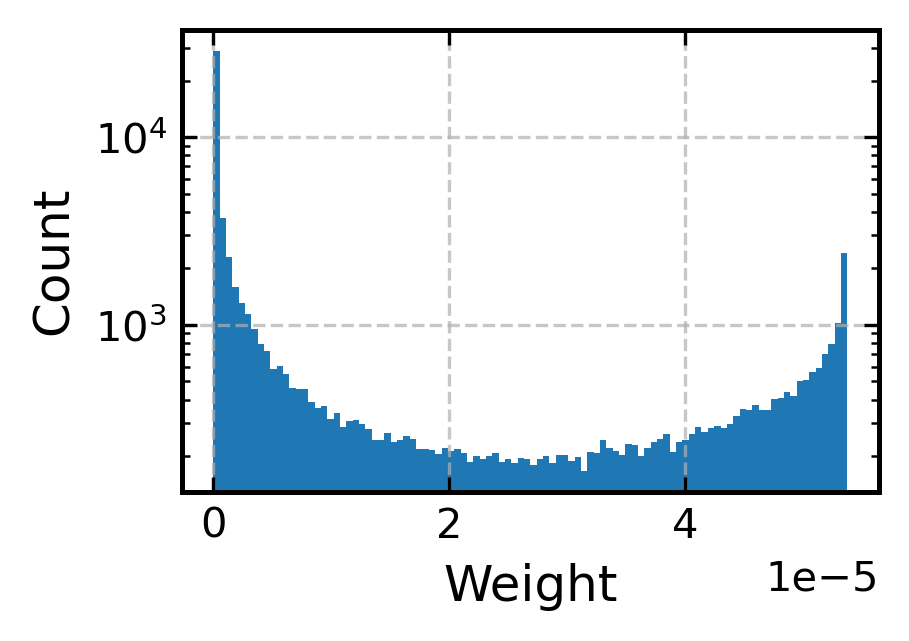

In [23]:
plt.figure(figsize = (3, 2))
plt.hist(weights_clean, bins=100)
plt.yscale('log')
plt.xlabel('Weight')
plt.ylabel('Count')
plt.show()